In [1]:
import os
import cv2
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.applications import MobileNetV2
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
IMG_SIZE = 224
SEED = 104
INIT_LR = 1e-4
EPOCHS = 20
Batch_Size = 32

In [3]:
DIRECTORY = "./dataset"
CATEGORIES = []

for i in os.listdir(DIRECTORY):
    CATEGORIES.append(i)

images = []
labels = []

for category in CATEGORIES:
	path = os.path.join(DIRECTORY, category)
	for i in tqdm(os.listdir(path)):
		img_path = os.path.join(path, i)
		img = load_img(img_path, target_size=(224, 224))
		img = img_to_array(img)
		img = preprocess_input(img)

		images.append(img)
		labels.append(category)

 66%|██████▌   | 1262/1915 [00:09<00:05, 113.65it/s]d:\anaconda3\envs\cvpr\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 1915/1915 [00:22<00:00, 85.09it/s] 


In [4]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

images = np.array(images, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(images, labels, test_size=0.20, stratify=labels, random_state=42)

In [5]:
train_gen = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.1,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.1,
	horizontal_flip=True,
	fill_mode="nearest",
)


In [6]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in baseModel.layers:
	layer.trainable = False

x = baseModel.output
x = layers.AveragePooling2D(pool_size=(7, 7))(x)
x = layers.Flatten(name="flatten")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=baseModel.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [7]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(
    loss="binary_crossentropy", 
    optimizer=opt, 
    metrics=["accuracy"]
)

In [8]:
checkpoint = ModelCheckpoint(
    filepath = './checkpoints/mobilenetV2_checkpoint_{epoch:02d}.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='auto',
    save_freq = 'epoch'
)

early_stp = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, restore_best_weights=True)

In [9]:
H = model.fit(
	train_gen.flow(trainX, trainY, batch_size=Batch_Size, seed = SEED),
	steps_per_epoch=len(trainX) // Batch_Size,
	validation_data=(testX, testY),
	validation_steps=len(testX) // Batch_Size,
	epochs=EPOCHS,
    callbacks=[checkpoint, early_stp]
)

# plt.savefig("plot.png")

Epoch 1/20
95/95 [==============================] - 97s 1s/step - loss: 0.3511 - accuracy: 0.8846 - val_loss: 0.1335 - val_accuracy: 0.9817
Epoch 2/20
95/95 [==============================] - 96s 1s/step - loss: 0.1271 - accuracy: 0.9703 - val_loss: 0.0682 - val_accuracy: 0.9896
Epoch 3/20
95/95 [==============================] - 86s 910ms/step - loss: 0.0872 - accuracy: 0.9746 - val_loss: 0.0508 - val_accuracy: 0.9909
Epoch 4/20
95/95 [==============================] - 92s 967ms/step - loss: 0.0751 - accuracy: 0.9769 - val_loss: 0.0435 - val_accuracy: 0.9935
Epoch 5/20
95/95 [==============================] - 74s 777ms/step - loss: 0.0664 - accuracy: 0.9819 - val_loss: 0.0400 - val_accuracy: 0.9935
Epoch 6/20
95/95 [==============================] - 70s 735ms/step - loss: 0.0482 - accuracy: 0.9878 - val_loss: 0.0361 - val_accuracy: 0.9922
Epoch 7/20
95/95 [==============================] - 70s 737ms/step - loss: 0.0473 - accuracy: 0.9878 - val_loss: 0.0340 - val_accuracy: 0.9922
Epoch

In [10]:
# make predictions on the testing set
preds = model.predict(testX, batch_size=Batch_Size)
preds = np.argmax(preds, axis=1)


print(classification_report(testY.argmax(axis=1), preds, target_names=lb.classes_))


24/24 [==============================] - 14s 514ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



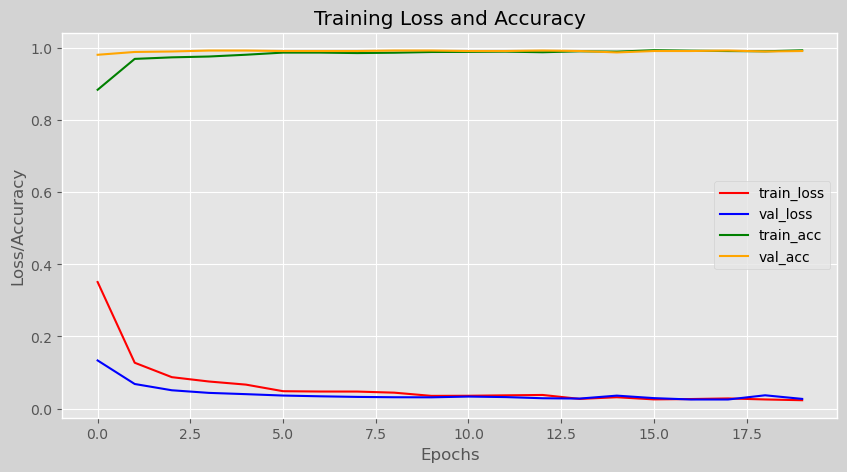

In [11]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(10, 5), dpi=100, facecolor='lightgray', edgecolor='k')
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss", color='red')
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss", color='blue')
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc", color='green')
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc", color='orange')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="right")
plt.show()

In [12]:
model.save("./f_mask_detector.model", save_format="h5")

In [13]:
model = load_model("./f_mask_detector.model")

In [15]:
cascPath = os.path.join(cv2.data.haarcascades, "./haarcascade_frontalface_alt2.xml")
faceCascade = cv2.CascadeClassifier(cascPath)

In [17]:
capture = cv2.VideoCapture(0)

if not capture.isOpened():
    raise IOError("cannot open camera")

while(capture.isOpened()):
    ret, frame = capture.read()
    
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(65, 65),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    faces_list = []
    for (x, y, w, h) in faces:
        face_frame = frame[y:y+h, x:x+w]
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        face_frame = cv2.resize(face_frame, (224, 224))
        face_frame = img_to_array(face_frame)
        face_frame = preprocess_input(face_frame)
        faces_list.append(face_frame)

    if len(faces_list) > 0:
        faces_list = np.array(faces_list)
        preds = model.predict(faces_list)
    else:
        preds = []

    for (x, y, w, h), pred in zip(faces, preds):
        (with_mask, without_mask) = pred
        
        if (with_mask > without_mask):
            label = "Mask Detected"
            color = (0, 160, 0)
        elif (without_mask >= with_mask):
            label = "No Mask Detected"
            color = (50, 50, 200)

        label = "{}: {:.2f}%".format(label, max(with_mask, without_mask) * 100)
        cv2.putText(frame, label, (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)


    cv2.imshow('Mask Detector', frame)

    c = cv2.waitKey(3)
    if c == 27: # ASCII of Esc
        break

capture.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 110ms/step
